In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('df_merged_networkanalysis.csv') 

In [2]:
df = df.drop('eid', axis=1)

In [3]:
depressive_symptoms  = ['Anhedonia', 'Depressed mood', 'Sleep problems', 'Fatigue',
       'Appetite changes', 'Feelings of inadequacy', 'Cognitive problems',
       'Psychomotor changes', 'Suicidal ideation']
    

metabolite_columns  = [ 'CRP', 'Alanine',
 'Glutamine',
 'Histidine',
 'Isoleucine',
 'Leucine',
 'Phenylalanine',
 'Tyrosine',
 'Valine',
 'Apolipoprotein A1',
 'Apolipoprotein B',
 'Total Esterified Cholesterol',
 'Total Free Cholesterol',
 'HDL Cholesterol',
 'LDL Cholesterol',
 'Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)',
 'Total Cholesterol',
 'VLDL Cholesterol',
 'Docosahexaenoic Acid',
 'Linoleic Acid',
 'Monounsaturated Fatty Acids',
 'Omega-3 Fatty Acids',
 'Omega-6 Fatty Acids',
 'Polyunsaturated Fatty Acids',
 'Saturated Fatty Acids',
 'Albumin',
 'Creatinine',
 'Phosphatidylcholines',
 'Total Triglycerides',
 'Total Cholines',
 'Sphingomyelins',
 'Phosphoglycerides',
 'Triglycerides in HDL',
 'Triglycerides in LDL',
 'Triglycerides in VLDL',
 'Citrate',
 'Glucose',
 'Lactate',
 'Glycoprotein Acetyls',
 '3-Hydroxybutyrate',
 'Acetate',
 'Acetoacetate',
 'Average Diameter for HDL Particles',
 'Average Diameter for LDL Particles',
 'Average Diameter for VLDL Particles',
 'Degree of Unsaturation',
 'Total Fatty Acids'
]

CVD_column = ['CVD']

# Select the columns from df
df2 = df[depressive_symptoms + metabolite_columns + CVD_column]


In [136]:
import pandas as pd
import pingouin as pg
from scipy import stats
import warnings

def compute_symptom_metabolite_correlation(df, depressive_symptoms, metabolite_columns):
    """
    Compute partial correlations between depressive symptoms and metabolites.
    """
    print("Computing partial correlations between depressive symptoms and metabolites...")

    # Suppress Intel MKL warnings (as they don't affect the results)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Intel MKL WARNING")

        # Convert relevant columns to numeric
        df[depressive_symptoms] = df[depressive_symptoms].apply(pd.to_numeric, errors='coerce')
        df[metabolite_columns] = df[metabolite_columns].apply(pd.to_numeric, errors='coerce')

        original_edges_symptom_metabolite = []

        # Analyze depressive symptoms ↔ metabolites (Spearman partial correlation)
        for metab in metabolite_columns:
            for symptom in depressive_symptoms:
                # Ensure no missing values in the columns being used
                subset = df[[metab, symptom]].dropna()
                if len(subset) < 2:
                    continue

                covariates = [col for col in df.columns if col not in [metab, symptom]]
                if covariates:  # Only calculate partial correlations if there are covariates
                    data = subset.join(df[covariates], how='inner')
                    partial_corr = pg.partial_corr(
                        data=data,
                        x=metab,
                        y=symptom,
                        covar=covariates,
                        method='spearman'
                    )
                    r = partial_corr["r"].values[0]
                    p_value = partial_corr["p-val"].values[0]
                    if p_value <= 0.05:
                        original_edges_symptom_metabolite.append({
                            "Metabolite": metab,
                            "Symptom": symptom,
                            "Partial Correlation (r)": r,
                            "p-value": p_value
                        })
                else:
                    print(f"Skipping partial correlation for {metab} - {symptom} due to no covariates.")

        # Create DataFrame and handle empty cases
        if original_edges_symptom_metabolite:
            original_partial_corr_symptom_metabolite = pd.DataFrame(original_edges_symptom_metabolite).sort_values(by="p-value")
        else:
            original_partial_corr_symptom_metabolite = pd.DataFrame(columns=["Metabolite", "Symptom", "Partial Correlation (r)", "p-value"])

        print("Partial correlation analysis between symptoms and metabolites completed.")
        return original_partial_corr_symptom_metabolite



import pandas as pd
import pingouin as pg
from scipy import stats
import warnings
import statsmodels.api as sm  # For robust residualization

def compute_metabolite_cvd_correlation(df, metabolite_columns, cvd_column):
    """
    Compute point-biserial correlations between metabolites and CVD,
    controlling for all other variables.
    """
    print("Computing correlations between metabolites and CVD...")

    # Suppress Intel MKL warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Intel MKL WARNING")

        # Convert relevant columns to numeric
        df.loc[:, metabolite_columns] = df[metabolite_columns].apply(pd.to_numeric, errors='coerce')
        cvd_column = cvd_column[0]
        df.loc[:, cvd_column] = pd.to_numeric(df[cvd_column], errors='coerce')

        original_edges_metabolite_cvd = []

        # Analyze metabolites ↔ CVD (Point-biserial correlation)
        for metab in metabolite_columns:
            # Identify covariates (all other columns except metabolite & CVD)
            covariates = [col for col in df.columns if col not in [metab, cvd_column]]

            # Select data with no missing values in the metabolite, CVD, or covariates
            subset = df[[metab, cvd_column] + covariates].dropna()

            if len(subset) < 2:
                print(f"Skipping {metab} - {cvd_column} due to insufficient data after handling missing values.")
                continue

            try:
                # Prepare data for regression
                X = subset[covariates]
                X = sm.add_constant(X)  # Add constant for intercept
                y_metab = subset[metab]
                y_cvd = subset[cvd_column]

                # Fit linear regression model to residualize metabolite
                metab_model = sm.OLS(y_metab, X).fit()
                x_resid = metab_model.resid  # Residuals for metabolite

                # Fit logistic regression model for CVD (binary outcome)
                cvd_model = sm.Logit(y_cvd, X).fit()
                y_pred = cvd_model.predict(X)  # Predicted probabilities
                y_resid = y_cvd - y_pred  # Residuals for CVD

                # Compute point-biserial correlation on residuals
                r, p_value = stats.pointbiserialr(y_resid, x_resid)

                if p_value <= 0.05:
                    original_edges_metabolite_cvd.append({
                        "Metabolite": metab,
                        "CVD": cvd_column,
                        "Partial Correlation (r)": r,
                        "p-value": p_value
                    })
            except Exception as e:
                print(f"Error processing {metab} - {cvd_column}: {e}")
                continue

        # Create DataFrame and handle empty cases
        if original_edges_metabolite_cvd:
            original_partial_corr_metabolite_cvd = pd.DataFrame(original_edges_metabolite_cvd).sort_values(by="p-value")
        else:
            original_partial_corr_metabolite_cvd = pd.DataFrame(columns=["Metabolite", "CVD", "Partial Correlation (r)", "p-value"])

        print("Partial correlation analysis between metabolites and CVD completed.")
        return original_partial_corr_metabolite_cvd



In [4]:
original_corr_symptom_metabolite = compute_symptom_metabolite_correlation(
    df=df2,
    depressive_symptoms=depressive_symptoms,
    metabolite_columns=metabolite_columns
)

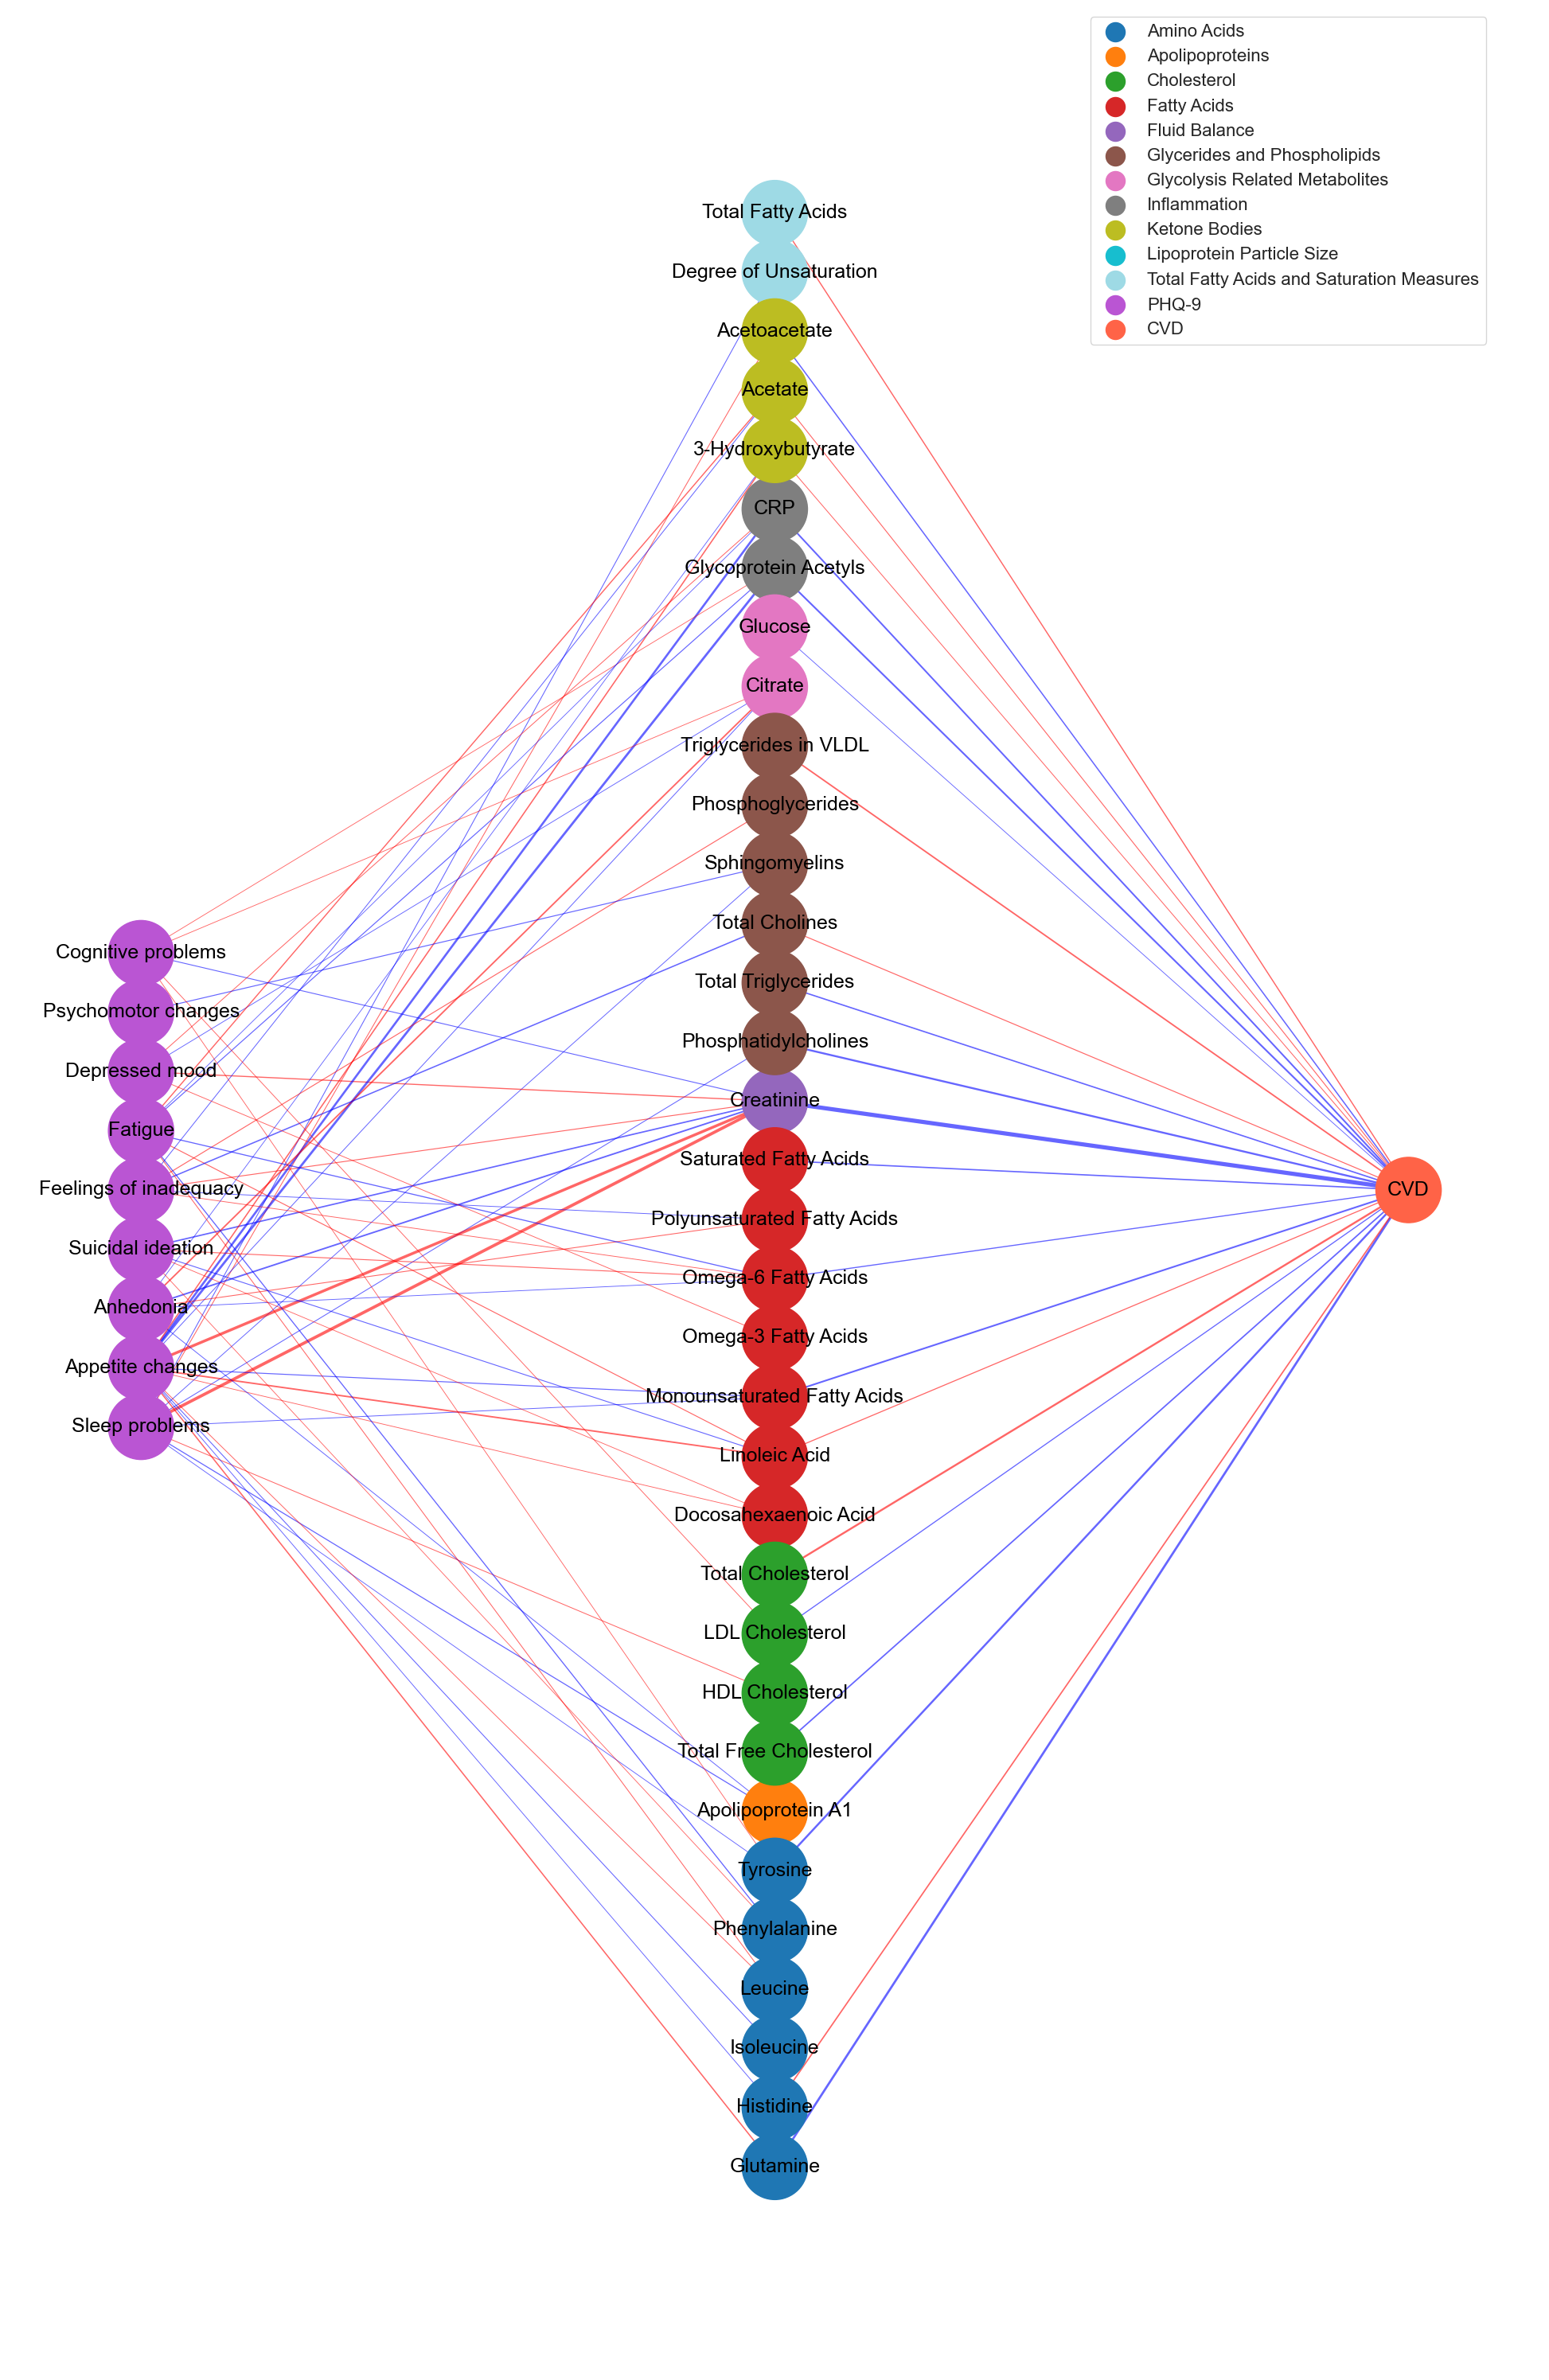

In [98]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_tripartite_network_partial_corr(symptom_metabolite_df, metabolite_cvd_df):
    if symptom_metabolite_df is None or metabolite_cvd_df is None:
        raise ValueError("Edge data is not available.")

    tripartite_graph = nx.Graph()

        # Add symptom → metabolite edges
    for _, row in symptom_metabolite_df.iterrows():
        symptom = row["Symptom"]
        metabolite = row["Metabolite"]
        weight = row["Partial Correlation (r)"]
        tripartite_graph.add_edge(symptom, metabolite, weight=weight)

    # Add metabolite → CVD edges
    for _, row in metabolite_cvd_df.iterrows():
        metabolite = row["Metabolite"]
        cvd = row["CVD"]
        weight = row["Partial Correlation (r)"]
        tripartite_graph.add_edge(metabolite, cvd, weight=weight)
    

    # Define metabolite groups and colors (as in your original code)
    metabolite_groups = {
        "Amino Acids": [
            "Alanine", "Glutamine", "Histidine", "Isoleucine", "Leucine",
            "Phenylalanine", "Tyrosine", "Valine"
        ],
        "Apolipoproteins": [
            "Apolipoprotein A1", "Apolipoprotein B"
        ],
        "Cholesterol": [
            'Total Esterified Cholesterol', 'Total Free Cholesterol',
            "HDL Cholesterol", "LDL Cholesterol", 
            "Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)",
            "Total Cholesterol", "VLDL Cholesterol"
        ],
        "Fatty Acids": [
            "Docosahexaenoic Acid", "Linoleic Acid", 
            "Monounsaturated Fatty Acids", "Omega-3 Fatty Acids", 
            "Omega-6 Fatty Acids", "Polyunsaturated Fatty Acids", 
            "Saturated Fatty Acids"
        ],
        "Fluid Balance": [
            "Albumin", "Creatinine"
        ],
        "Glycerides and Phospholipids": [
            "Phosphatidylcholines", "Total Triglycerides", "Total Cholines",
            "Sphingomyelins", "Phosphoglycerides", "Triglycerides in HDL",
            "Triglycerides in LDL", "Triglycerides in VLDL"
        ],
        "Glycolysis Related Metabolites": [
            "Citrate", "Glucose", "Lactate"
        ],
        "Inflammation": [
            "Glycoprotein Acetyls", 'CRP'
        ],
        "Ketone Bodies": [
            "3-Hydroxybutyrate", "Acetate", "Acetoacetate"
        ],
        "Lipoprotein Particle Size": [
            "Average Diameter for HDL Particles", "Average Diameter for LDL Particles",
            "Average Diameter for VLDL Particles"
        ],
        "Total Fatty Acids and Saturation Measures": [
            "Degree of Unsaturation", "Total Fatty Acids"
        ]
    }

    # Assign colors to metabolite groups
    metabolite_colors = {
        "Amino Acids": '#1f77b4',
        "Apolipoproteins": '#ff7f0e',
        "Cholesterol": '#2ca02c',
        "Fatty Acids": '#d62728',
        "Fluid Balance": '#9467bd',
        "Glycerides and Phospholipids": '#8c564b',
        "Glycolysis Related Metabolites": '#e377c2',
        "Inflammation": '#7f7f7f',
        "Ketone Bodies": '#bcbd22',
        "Lipoprotein Particle Size": '#17becf',
        "Total Fatty Acids and Saturation Measures": '#9edae5'
    }

    # Define symptom groups
    phq_9_symptoms = {'Anhedonia', 'Depressed mood', 'Sleep problems', 'Fatigue', 'Appetite changes', 'Feelings of inadequacy', 'Cognitive problems', 'Psychomotor changes', 'Suicidal ideation'}
    gad_7_symptoms = {'Anxiety', 'Worrying control', 'Generalized worrying', 'Lack of relaxation', 'Restlessness', 'Irritability', 'Foreboding'}

    # Assign colors to nodes
    node_colors = {}
    for group, metabolites in metabolite_groups.items():
        for metabolite in metabolites:
            if metabolite in tripartite_graph.nodes():
                node_colors[metabolite] = metabolite_colors[group]

    symptom_colors = {node: '#BA55D3' for node in tripartite_graph.nodes() if node in phq_9_symptoms}
    symptom_colors.update({node: '#FFA500' for node in tripartite_graph.nodes() if node in gad_7_symptoms})
    
    # Assign a color for CVD nodes
    cvd_color = '#FF6347'  # Tomato color for CVD nodes
    cvd_nodes = set(metabolite_cvd_df['CVD'])  # Use the 'CVD' column instead
    for node in cvd_nodes:
        node_colors[node] = cvd_color

    # Combine all node colors
    all_node_colors = {**node_colors, **symptom_colors}

    # Calculate optimal node spacing
    space_multiplier = max(80, 14000 / max(len(tripartite_graph.nodes()) // 3, 1))  # Increased spacing

    # Assign positions for tripartite layout
    pos = {}
    symptom_x, metabolite_x, cvd_x = 1, 2, 3

        # Calculate the total height needed for each column
    symptom_height = len([n for n in tripartite_graph.nodes() if n in phq_9_symptoms or n in gad_7_symptoms]) * space_multiplier
    metabolite_height = len([n for n in tripartite_graph.nodes() if n in [m for group in metabolite_groups.values() for m in group]]) * space_multiplier
    cvd_height = len(cvd_nodes) * space_multiplier

    max_height = max(symptom_height, metabolite_height, cvd_height)

    # Position symptom nodes on the left (centered)
    current_y = (max_height - symptom_height) / 2
    for node in tripartite_graph.nodes():
        if node in phq_9_symptoms or node in gad_7_symptoms:
            pos[node] = (symptom_x, current_y)
            current_y += space_multiplier

    # Position metabolite nodes in the middle
    current_y = (max_height - metabolite_height) / 2
    for group, metabolites in metabolite_groups.items():
        for metabolite in metabolites:
            if metabolite in tripartite_graph.nodes():
                pos[metabolite] = (metabolite_x, current_y)
                current_y += space_multiplier

    # Position CVD nodes on the right (centered)
    current_y = (max_height - cvd_height) / 2
    for node in cvd_nodes:
        pos[node] = (cvd_x, current_y)
        current_y += space_multiplier
        
    offset_x = 0.7
    symptom_x, metabolite_x, cvd_x = 1.5 + offset_x, 2.5 + offset_x, 3.5 + offset_x



    # Configure plot size
    plt.figure(figsize=(20, 30))  # Increased figure size

    # Drawing nodes
    nx.draw_networkx_nodes(tripartite_graph, pos, node_color=[all_node_colors.get(node, '#CCCCCC') for node in tripartite_graph.nodes()], node_size=3500)  # Increased node size

    # Prepare edge colors and weights
    edges = tripartite_graph.edges(data=True)
    edge_colors = ['blue' if d['weight'] > 0 else 'red' for _, _, d in edges]
    edge_weights = [abs(d['weight'] * 60) for _, _, d in edges]  # Increased edge weight scaling

    # Drawing edges with weights and colors
    nx.draw_networkx_edges(tripartite_graph, pos, edgelist=edges, width=edge_weights, edge_color=edge_colors, alpha=0.6)

    # Drawing node labels
    nx.draw_networkx_labels(tripartite_graph, pos, font_size=18, font_color='black')  # Increased font size

    # Add a legend for node groups
    for group, color in metabolite_colors.items():
        plt.scatter([], [], color=color, label=group, s=300)  # Increased legend marker size
    plt.scatter([], [], color='#BA55D3', label='PHQ-9', s=300)
 
    plt.scatter([], [], color=cvd_color, label='CVD', s=300)

    #plt.legend(scatterpoints=1, fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))  # Legend in upper left corner
    plt.legend(scatterpoints=1, fontsize=16, loc='upper left', bbox_to_anchor=(0.7, 1))
    plt.axis('off')  # Turn off the axis
    plt.tight_layout()  # Adjust layout to make room for plot elements
    plt.savefig("tripartite_network.tiff", dpi=600, bbox_inches='tight')  
    plt.show()

    return tripartite_graph

tripartite_graph = visualize_tripartite_network_partial_corr(
    symptom_metabolite_df=original_corr_symptom_metabolite,
    metabolite_cvd_df=original_corr_metabolite_cvd
)



In [5]:
import pandas as pd
import numpy as np
import pingouin as pg
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import statsmodels.api as sm

class MetaboliteSymptomNetwork:
    def __init__(self, df, depressive_symptoms, metabolite_columns, cvd_column, n_bootstrap=50):
        self.df = df
        self.depressive_symptoms = depressive_symptoms
        self.metabolite_columns = metabolite_columns
        self.cvd_column = cvd_column
        self.n_bootstrap = n_bootstrap
        self.edge_stats_symptom_metabolite = {}
        self.edge_stats_metabolite_cvd = {}
        self.edge_stability_table_symptom_metabolite = None
        self.edge_stability_table_metabolite_cvd = None

    def compute_symptom_metabolite_correlation(self, data):
        edges = []
        for metab in self.metabolite_columns:
            for symptom in self.depressive_symptoms:
                subset = data[[metab, symptom]].dropna()
                if len(subset) < 2:
                    continue
                covariates = [col for col in data.columns if col not in [metab, symptom]]
                if covariates:
                    data_subset = subset.join(data[covariates], how='inner')
                    partial_corr = pg.partial_corr(
                        data=data_subset,
                        x=metab,
                        y=symptom,
                        covar=covariates,
                        method='spearman'
                    )
                    r = partial_corr["r"].values[0]
                    p_value = partial_corr["p-val"].values[0]
                    if p_value <= 0.05:
                        edges.append((metab, symptom, r))
        return edges

    def compute_metabolite_cvd_correlation(self, data):
        edges = []
        cvd_column = self.cvd_column[0]
        for metab in self.metabolite_columns:
            covariates = [col for col in data.columns if col not in [metab, cvd_column]]
            subset = data[[metab, cvd_column] + covariates].dropna()
            if len(subset) < 2:
                continue
            try:
                X = sm.add_constant(subset[covariates])
                y_metab = subset[metab]
                y_cvd = subset[cvd_column]

                metab_model = sm.OLS(y_metab, X).fit()
                x_resid = metab_model.resid

                cvd_model = sm.Logit(y_cvd, X).fit()
                y_pred = cvd_model.predict(X)
                y_resid = y_cvd - y_pred

                r, p_value = stats.pointbiserialr(y_resid, x_resid)
                if p_value <= 0.05:
                    edges.append((metab, cvd_column, r))
            except Exception as e:
                print(f"Error processing {metab} - {cvd_column}: {e}")
        return edges

    def bootstrap_analysis(self):
        print("Performing bootstrap analysis...")
        data = self.df[self.depressive_symptoms + self.metabolite_columns + self.cvd_column]

        for i in range(self.n_bootstrap):
            print(f"Bootstrap iteration: {i + 1}/{self.n_bootstrap}")
            resampled_data = data.sample(frac=1, replace=True, random_state=i)

            edges_symptom_metabolite = self.compute_symptom_metabolite_correlation(resampled_data)
            edges_metabolite_cvd = self.compute_metabolite_cvd_correlation(resampled_data)

            for edge in edges_symptom_metabolite:
                key = (edge[0], edge[1])
                if key not in self.edge_stats_symptom_metabolite:
                    self.edge_stats_symptom_metabolite[key] = {"count": 0, "weights": []}
                self.edge_stats_symptom_metabolite[key]["count"] += 1
                self.edge_stats_symptom_metabolite[key]["weights"].append(edge[2])

            for edge in edges_metabolite_cvd:
                key = (edge[0], edge[1])
                if key not in self.edge_stats_metabolite_cvd:
                    self.edge_stats_metabolite_cvd[key] = {"count": 0, "weights": []}
                self.edge_stats_metabolite_cvd[key]["count"] += 1
                self.edge_stats_metabolite_cvd[key]["weights"].append(edge[2])

        self.process_edge_stability()
        print("Bootstrap analysis completed.")

    def process_edge_stability(self):
        edge_stability_symptom_metabolite = []
        for edge, stats in self.edge_stats_symptom_metabolite.items():
            frequency = stats["count"] / self.n_bootstrap
            mean_weight = np.mean(stats["weights"])
            std_weight = np.std(stats["weights"])
            edge_stability_symptom_metabolite.append({
                "Edge": edge,
                "Frequency": frequency,
                "Mean Weight": mean_weight,
                "Weight Std": std_weight
            })

        edge_stability_metabolite_cvd = []
        for edge, stats in self.edge_stats_metabolite_cvd.items():
            frequency = stats["count"] / self.n_bootstrap
            mean_weight = np.mean(stats["weights"])
            std_weight = np.std(stats["weights"])
            edge_stability_metabolite_cvd.append({
                "Edge": edge,
                "Frequency": frequency,
                "Mean Weight": mean_weight,
                "Weight Std": std_weight
            })

        self.edge_stability_table_symptom_metabolite = pd.DataFrame(edge_stability_symptom_metabolite).sort_values(by="Frequency", ascending=False)
        self.edge_stability_table_metabolite_cvd = pd.DataFrame(edge_stability_metabolite_cvd).sort_values(by="Frequency", ascending=False)

    def get_edge_stability_tables(self):
        if self.edge_stability_table_symptom_metabolite is None or self.edge_stability_table_metabolite_cvd is None:
            raise ValueError("Edge stability data is not available. Run bootstrap_analysis() first.")
        return self.edge_stability_table_symptom_metabolite, self.edge_stability_table_metabolite_cvd

# Usage remains the same
network = MetaboliteSymptomNetwork(
    df=df2,
    depressive_symptoms=depressive_symptoms,
    metabolite_columns=metabolite_columns,
    cvd_column=['CVD'],
    n_bootstrap=50
)

network.bootstrap_analysis()


In [6]:
edge_stability_table_symptom_metabolite, edge_stability_table_metabolite_cvd = network.get_edge_stability_tables()

In [7]:
def swap_cvd_first(edge):
    if isinstance(edge, tuple):
        return (edge[1], edge[0])
    elif isinstance(edge, str):
        try:
            # Try to safely evaluate the string as a tuple
            edge_tuple = ast.literal_eval(edge)
            return f"({edge_tuple[1]}, {edge_tuple[0]})"
        except:
            # If it's not a valid tuple string, split by comma
            parts = edge.strip('()').split(', ')
            return f"({parts[-1]}, {', '.join(parts[:-1])})"
    else:
        return edge  # Return unchanged if it's neither tuple nor string

# Apply the swapping function to the 'Edge' column
edge_stability_table_symptom_metabolite['Edge'] = edge_stability_table_symptom_metabolite['Edge'].apply(swap_cvd_first)


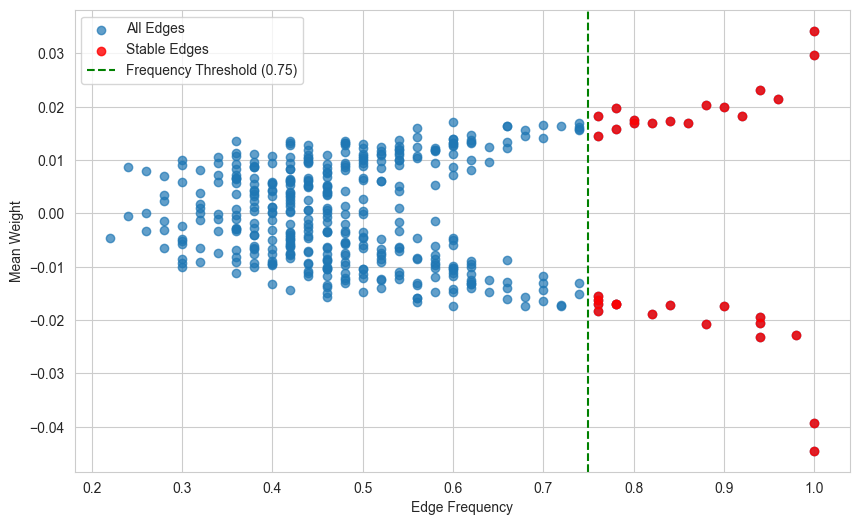

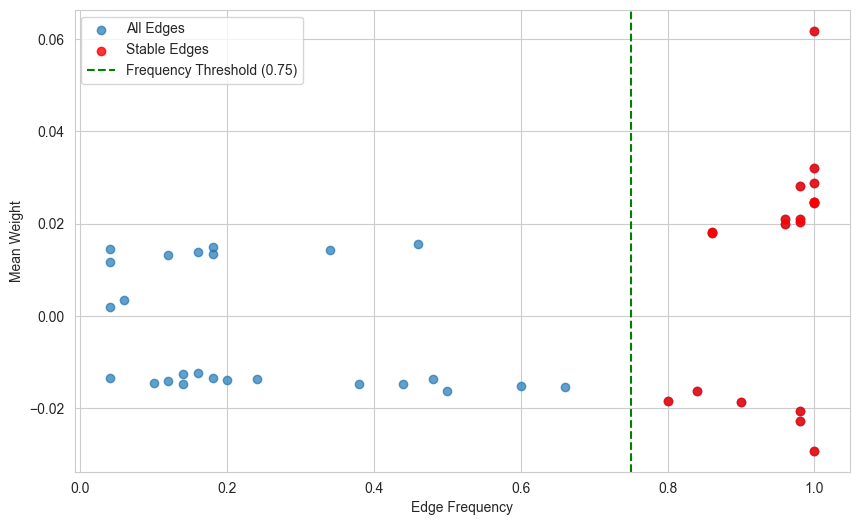

In [57]:
import matplotlib.pyplot as plt

def plot_edge_stability(edge_stability_df, title, frequency_threshold=0.75):
    """
    Plots the edge stability based on bootstrap results.

    Parameters:
    - edge_stability_df: DataFrame with columns ['Frequency', 'Mean Weight']
    - title: Title of the plot (e.g., "Metabolite ↔ Symptoms" or "Metabolite ↔ CVD")
    - frequency_threshold: Threshold above which edges are considered stable (default=0.75)
    """
    if edge_stability_df is None or edge_stability_df.empty:
        raise ValueError(f"Edge stability data for {title} is not available.")

    stable_edges = edge_stability_df[edge_stability_df["Frequency"] >= frequency_threshold]

    plt.figure(figsize=(10, 6))
    plt.scatter(
        edge_stability_df["Frequency"], 
        edge_stability_df["Mean Weight"], 
        alpha=0.7, 
        label="All Edges"
    )
    plt.scatter(
        stable_edges["Frequency"], 
        stable_edges["Mean Weight"], 
        color='red', 
        alpha=0.8, 
        label="Stable Edges"
    )
    plt.axvline(x=frequency_threshold, color='green', linestyle='--', label=f'Frequency Threshold ({frequency_threshold})')
    plt.xlabel("Edge Frequency")
    plt.ylabel("Mean Weight")
    plt.legend()
   # plt.title(f"Edge Stability: {title}")
    plt.show()


# Run the function for both networks
plot_edge_stability(edge_stability_table_symptom_metabolite, "Metabolite ↔ Symptoms", frequency_threshold=0.75)
plot_edge_stability(edge_stability_table_metabolite_cvd, "Metabolite ↔ CVD", frequency_threshold=0.75)


/var/folders/fk/bblmdmdn30xgvg8f32cv_y580000gn/T/ipykernel_78881/111233866.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Edge'] = df_filtered['Edge'].apply(lambda x: f"{x[0]}, {x[1]}")


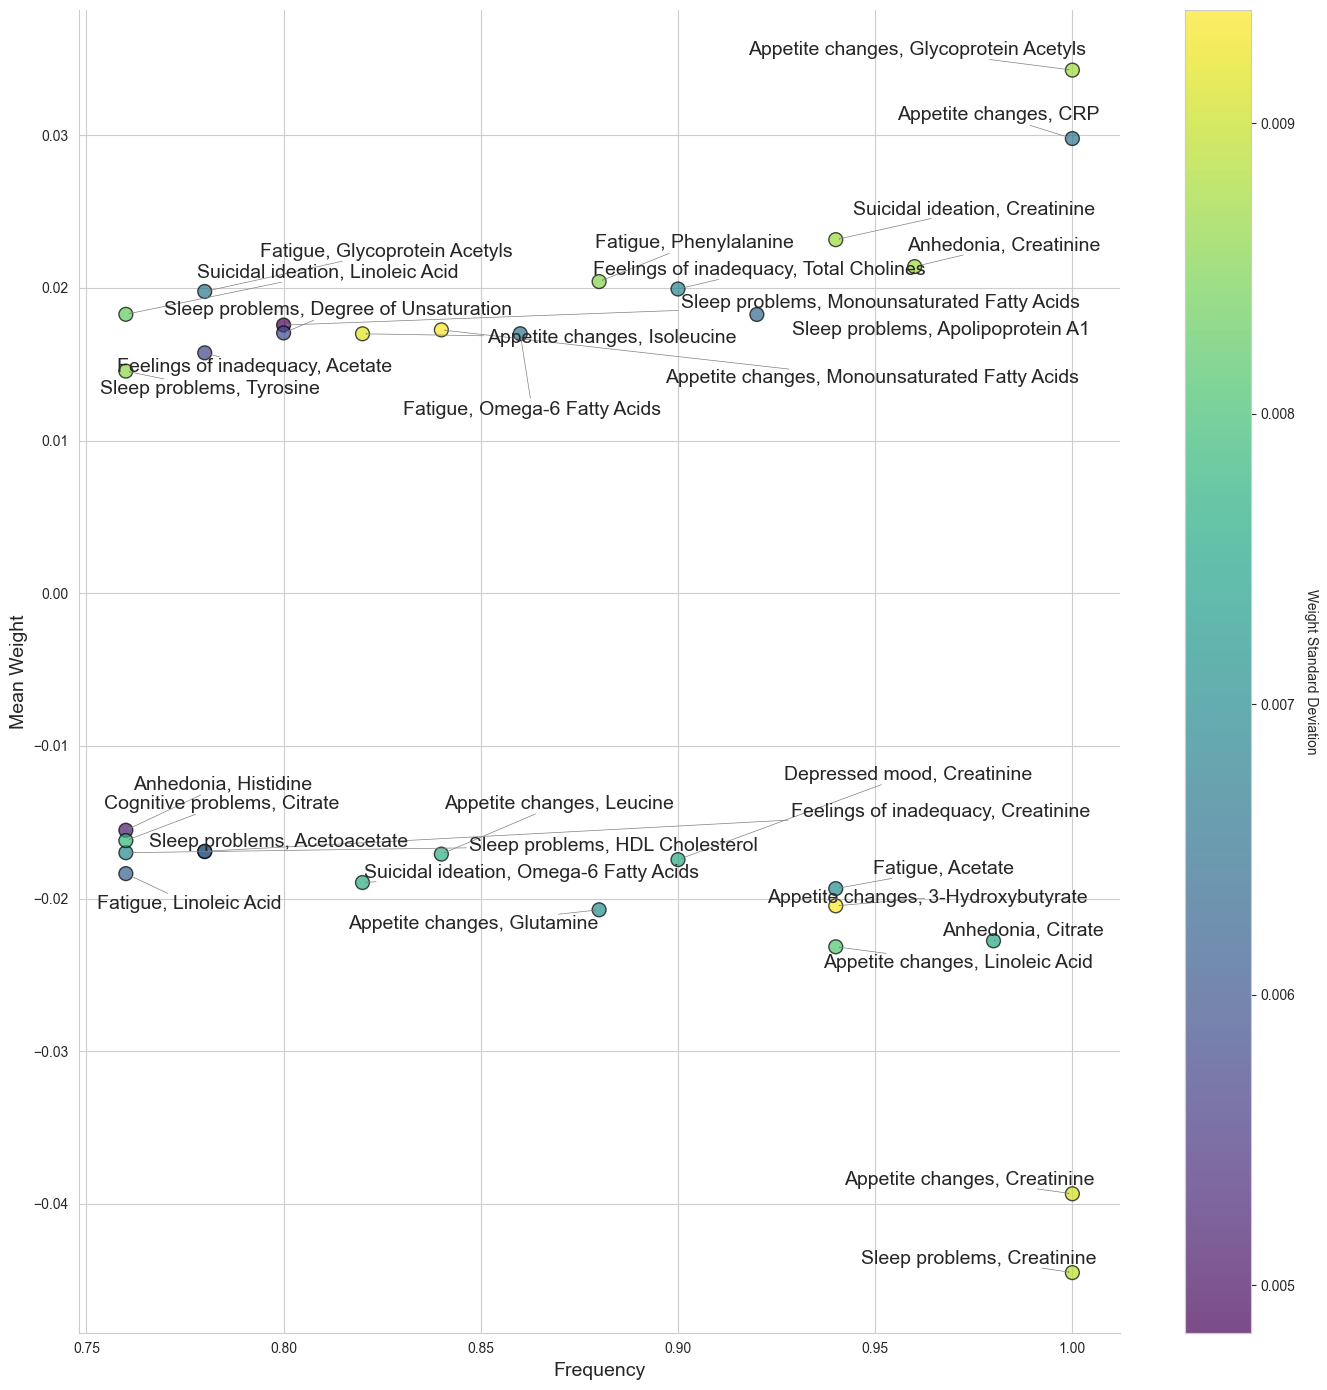

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from adjustText import adjust_text

# Assuming edge_stability_table_metabolite_cvd is your DataFrame
df = edge_stability_table_symptom_metabolite.copy()

# Filter out rows where Frequency is less than or equal to 0.75
df_filtered = df[df['Frequency'] > 0.75]

# Format the 'Edge' column for display
df_filtered['Edge'] = df_filtered['Edge'].apply(lambda x: f"{x[0]}, {x[1]}")

# Set up the plot
plt.figure(figsize=(14, 14))
sns.set_style("whitegrid")

# Create the scatter plot
scatter = plt.scatter(df_filtered['Frequency'], df_filtered['Mean Weight'], 
                      c=df_filtered['Weight Std'], cmap='viridis', 
                      s=100, alpha=0.7, edgecolors='black')

# Customize the plot
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Mean Weight', fontsize=14)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Weight Standard Deviation', rotation=270, labelpad=16)

# Create annotations
texts = []
for i, txt in enumerate(df_filtered['Edge']):
    texts.append(plt.text(df_filtered['Frequency'].iloc[i], df_filtered['Mean Weight'].iloc[i], txt, fontsize=14))

# Adjust text positions to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=0.5))

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()


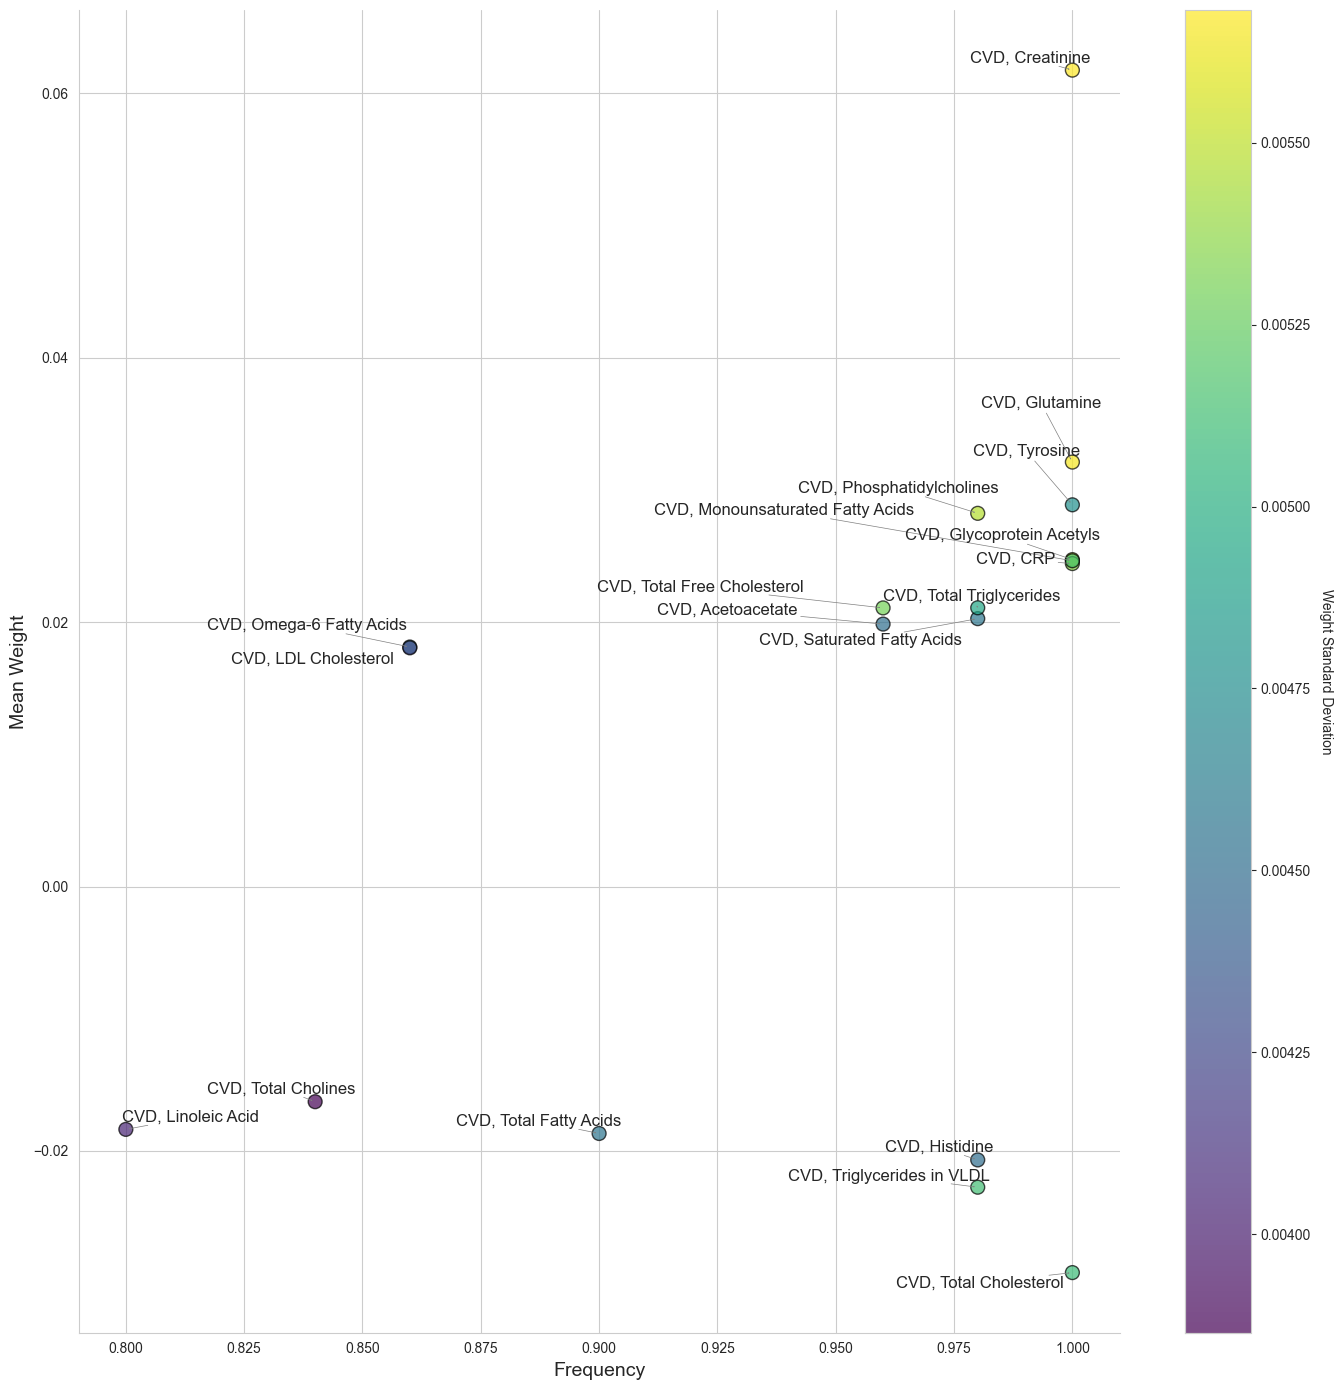

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from adjustText import adjust_text

# Assuming edge_stability_table_metabolite_cvd is your DataFrame
df = edge_stability_table_metabolite_cvd.copy()

# Filter out rows where Frequency is less than or equal to 0.5
df_filtered = df[df['Frequency'] > 0.75].copy()

# ✅ Correct formatting of the 'Edge' column
df_filtered['Edge'] = df_filtered['Edge'].astype(str).str.replace(r"[\(\)]", "", regex=True)


# Set up the plot
plt.figure(figsize=(14, 14))
sns.set_style("whitegrid")

# Create the scatter plot
scatter = plt.scatter(df_filtered['Frequency'], df_filtered['Mean Weight'], 
                      c=df_filtered['Weight Std'], cmap='viridis', 
                      s=100, alpha=0.7, edgecolors='black')

# Customize the plot
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Mean Weight', fontsize=14)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Weight Standard Deviation', rotation=270, labelpad=16)

# Create annotations: Ensure the text is properly formatted without parentheses
texts = []
for i, txt in enumerate(df_filtered['Edge']):
    # Place text with correct formatting
    texts.append(plt.text(df_filtered['Frequency'].iloc[i], df_filtered['Mean Weight'].iloc[i], 
                          txt, fontsize=12, ha='right', va='bottom'))

# Adjust text positions to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=0.5))

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()


In [103]:
filtered_data1 = edge_stability_table_symptom_metabolite[edge_stability_table_symptom_metabolite['Frequency'] > 0.75]




In [109]:

# Filter rows where 'Frequency' is greater than 0.5
filtered_data2 = edge_stability_table_metabolite_cvd[edge_stability_table_metabolite_cvd['Frequency'] > 0.75]

# Extract metabolites from the 'Edge' column
metabolites_list2 = filtered_data2['Edge'].apply(lambda x: x.split(', ')[1].strip(')') if isinstance(x, str) else None).tolist()

# Remove any None values, if present
metabolites_list2 = [metabolite for metabolite in metabolites_list2 if metabolite is not None]

# Print the list of metabolites
print(metabolites_list2)



['Glutamine', 'Glycoprotein Acetyls', 'Tyrosine', 'CRP', 'Total Cholesterol', 'Creatinine', 'Monounsaturated Fatty Acids', 'Saturated Fatty Acids', 'Histidine', 'Triglycerides in VLDL', 'Total Triglycerides', 'Phosphatidylcholines', 'Acetoacetate', 'Total Free Cholesterol', 'Total Fatty Acids', 'Omega-6 Fatty Acids', 'LDL Cholesterol', 'Total Cholines', 'Linoleic Acid']


In [114]:
import ast

# Filter rows where 'Frequency' is greater than 0.75
filtered_data1 = edge_stability_table_symptom_metabolite[edge_stability_table_symptom_metabolite['Frequency'] > 0.75]

# Extract edges as a list of strings
metabolites_list1 = filtered_data1['Edge'].tolist()

# Convert string tuples to actual tuples and extract the second element (metabolite)
metabolites_only = [ast.literal_eval(edge)[1] for edge in metabolites_list1]

# Print the extracted metabolite names
print(metabolites_only)


['CRP', 'Creatinine', 'Creatinine', 'Glycoprotein Acetyls', 'Citrate', 'Creatinine', 'Creatinine', 'Acetate', '3-Hydroxybutyrate', 'Linoleic Acid', 'Apolipoprotein A1', 'Creatinine', 'Total Cholines', 'Glutamine', 'Phenylalanine', 'Omega-6 Fatty Acids', 'Monounsaturated Fatty Acids', 'Leucine', 'Isoleucine', 'Omega-6 Fatty Acids', 'Monounsaturated Fatty Acids', 'Degree of Unsaturation', 'Glycoprotein Acetyls', 'Acetoacetate', 'Acetate', 'Creatinine', 'Histidine', 'Linoleic Acid', 'Linoleic Acid', 'Tyrosine', 'HDL Cholesterol', 'Citrate']


In [115]:
common_elements = list(set(metabolites_only) & set(metabolites_list2))

# Print the common elements
print(common_elements)

['Tyrosine', 'Acetoacetate', 'Glycoprotein Acetyls', 'Histidine', 'Omega-6 Fatty Acids', 'Creatinine', 'CRP', 'Monounsaturated Fatty Acids', 'Linoleic Acid', 'Glutamine', 'Total Cholines']


In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filter rows where 'Frequency' is greater than 0.5
filtered_data1 = edge_stability_table_symptom_metabolite[edge_stability_table_symptom_metabolite['Frequency'] > 0.75]

# Filter rows where 'Frequency' is greater than 0.5
filtered_data2 = edge_stability_table_metabolite_cvd[edge_stability_table_metabolite_cvd['Frequency'] > 0.75]

# Extract metabolites from the 'Edge' column
metabolites_list = filtered_data2['Edge'].apply(lambda x: x.split(', ')[1].strip(')') if isinstance(x, str) else None).tolist()


# Combine both datasets
combined_edges = pd.concat([filtered_data1, filtered_data2])

# Function to extract 'Variable' and 'Metabolite' from 'Edge' column
def extract_edge_pair_and_fix(edge):
    if isinstance(edge, tuple) and len(edge) == 2:
        return edge
    elif isinstance(edge, str):
        parts = edge.strip('()').split(', ')
        if len(parts) == 2:
            if 'CVD' in parts:
                return ('CVD', parts[0] if parts[1] == 'CVD' else parts[1])
            else:
                return tuple(parts)
    return (np.nan, np.nan)

# Apply the function to the 'Edge' column and create 'Variable' and 'Metabolite' columns
combined_edges[['Variable', 'Metabolite']] = pd.DataFrame(
    combined_edges['Edge'].apply(extract_edge_pair_and_fix).tolist(), 
    index=combined_edges.index
)

cleaned_metabolites = combined_edges['Metabolite'].unique()


import numpy as np

# Convert array to a cleaned list
cleaned_metabolites = np.unique([metab.strip("'") for metab in combined_edges['Metabolite'].unique()])

print(cleaned_metabolites)


['3-Hydroxybutyrate' 'Acetate' 'Acetoacetate' 'Apolipoprotein A1' 'CRP'
 'Citrate' 'Creatinine' 'Degree of Unsaturation' 'Glutamine'
 'Glycoprotein Acetyls' 'HDL Cholesterol' 'Histidine' 'Isoleucine'
 'LDL Cholesterol' 'Leucine' 'Linoleic Acid' 'Monounsaturated Fatty Acids'
 'Omega-6 Fatty Acids' 'Phenylalanine' 'Phosphatidylcholines'
 'Saturated Fatty Acids' 'Total Cholesterol' 'Total Cholines'
 'Total Fatty Acids' 'Total Free Cholesterol' 'Total Triglycerides'
 'Triglycerides in VLDL' 'Tyrosine']


In [118]:
metabolites_list = ['3-Hydroxybutyrate' 'Acetate' 'Acetoacetate' 'Apolipoprotein A1' 'CRP'
 'Citrate' 'Creatinine' 'Degree of Unsaturation' 'Glutamine'
 'Glycoprotein Acetyls' 'HDL Cholesterol' 'Histidine' 'Isoleucine'
 'LDL Cholesterol' 'Leucine' 'Linoleic Acid' 'Monounsaturated Fatty Acids'
 'Omega-6 Fatty Acids' 'Phenylalanine' 'Phosphatidylcholines'
 'Saturated Fatty Acids' 'Total Cholesterol' 'Total Cholines'
 'Total Fatty Acids' 'Total Free Cholesterol' 'Total Triglycerides'
 'Triglycerides in VLDL' 'Tyrosine']

metabolites_list = common_elements

In [8]:
# Remove extra quotes from 'Edge', 'Variable', and 'Metabolite' columns
combined_edges[['Edge', 'Variable', 'Metabolite']] = combined_edges[['Edge', 'Variable', 'Metabolite']].replace("'", "", regex=True)


Unique Variables (Y-axis): ['Appetite changes' 'Sleep problems' 'Anhedonia' 'Suicidal ideation'
 'Depressed mood' 'Feelings of inadequacy' 'Fatigue' 'CVD']


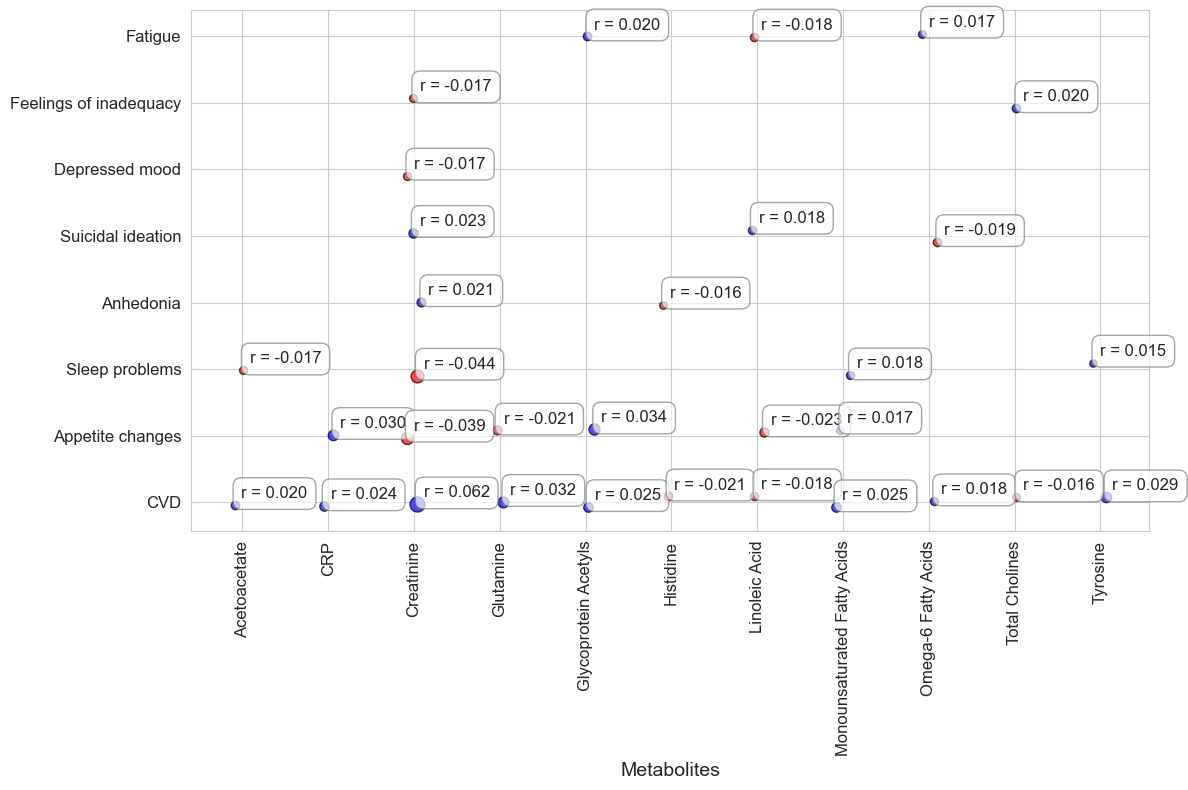


Plotted Pairs of Connected Metabolites, CVD, and Symptoms:
('CVD', 'Acetoacetate')
('CVD', 'CRP')
('CVD', 'Creatinine')
('CVD', 'Glutamine')
('CVD', 'Glycoprotein Acetyls')
('CVD', 'Histidine')
('CVD', 'Linoleic Acid')
('CVD', 'Monounsaturated Fatty Acids')
('CVD', 'Omega-6 Fatty Acids')
('CVD', 'Total Cholines')
('CVD', 'Tyrosine')
('Appetite changes', 'CRP')
('Appetite changes', 'Creatinine')
('Appetite changes', 'Glutamine')
('Appetite changes', 'Glycoprotein Acetyls')
('Appetite changes', 'Linoleic Acid')
('Appetite changes', 'Monounsaturated Fatty Acids')
('Sleep problems', 'Acetoacetate')
('Sleep problems', 'Creatinine')
('Sleep problems', 'Monounsaturated Fatty Acids')
('Sleep problems', 'Tyrosine')
('Anhedonia', 'Creatinine')
('Anhedonia', 'Histidine')
('Suicidal ideation', 'Creatinine')
('Suicidal ideation', 'Linoleic Acid')
('Suicidal ideation', 'Omega-6 Fatty Acids')
('Depressed mood', 'Creatinine')
('Feelings of inadequacy', 'Creatinine')
('Feelings of inadequacy', 'Total 

In [152]:
# Ensure "Variable" contains symptoms + CVD (not metabolites)
filtered_combined_edges = combined_edges[
    (~combined_edges['Variable'].isin(metabolites_list)) &  # Exclude metabolites from Variable
    (combined_edges['Metabolite'].isin(metabolites_list))   # Keep only metabolites in Metabolite
]

# Verify that Variable contains symptoms + CVD
print("Unique Variables (Y-axis):", filtered_combined_edges['Variable'].unique())

# Ensure CVD-related variables appear first in the y-axis
cvd_variables = ['CVD']  # Replace with actual CVD variable names
symptom_variables = [var for var in filtered_combined_edges['Variable'].unique() if var not in cvd_variables]
symptom_variables
# Define a custom order with CVD variables first
ordered_variables = cvd_variables + symptom_variables

# Pivot table: Symptoms & CVD (y-axis), Metabolites (x-axis), Mean Weight (values)
pivot_data = filtered_combined_edges.pivot_table(
    index='Variable',  # Symptoms + CVD (y-axis)
    columns='Metabolite',  # Metabolites (x-axis)
    values='Mean Weight',
    aggfunc='mean'
).reindex(ordered_variables)  # Apply custom ordering

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))  # Adjusted size for better clarity

# List to store the pairs that are plotted
plotted_pairs = []

# Plot each edge, with the size and color based on 'Mean Weight'
for i, variable in enumerate(pivot_data.index):
    for j, metabolite in enumerate(pivot_data.columns):
        weight = pivot_data.iloc[i, j]
        if not np.isnan(weight):  # Plot only if there's a valid weight
            # Choose color based on the weight (blue for positive, red for negative)
            color = 'blue' if weight > 0 else 'red'
            
            # Random slight offset for the "rain" effect
            x_pos = j + np.random.uniform(-0.1, 0.1)  # Random slight offset for x-axis
            y_pos = i + np.random.uniform(-0.1, 0.1)  # Random slight offset for y-axis

            # Adjust size by the absolute value of the weight and make the circles bigger
            size = np.abs(weight) * 1900  # Larger size factor for better visibility

            # Plotting the circle (rain-like, with color and size based on weight)
            ax.scatter(x_pos, y_pos, c=color, s=size, alpha=0.7, edgecolors='black', marker='o')  # Circular markers

            # Annotate the plot with the mean weight value in the format: r = mean value
            ax.annotate(f'r = {weight:.3f}', (x_pos, y_pos), xytext=(5, 5), textcoords='offset points',
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.7))

            # Store the pair of connected metabolites, CVD, and symptoms in the plotted_pairs list
            plotted_pairs.append((variable, metabolite))

# Set axis labels and titles
ax.set_xlabel("Metabolites", fontsize=14)

# Set tick labels with larger font
ax.set_xticks(range(len(pivot_data.columns)))
ax.set_xticklabels(pivot_data.columns, rotation=90, fontsize=12)
ax.set_yticks(range(len(pivot_data.index)))
ax.set_yticklabels(pivot_data.index, fontsize=12)

# Adjust the color map so that blue represents positive, and red represents negative
sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=plt.Normalize(vmin=-1, vmax=1))  # 'coolwarm_r' reverses the color map
sm.set_array([])  # Empty array for the colorbar
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label("Mean Weight", fontsize=14)

# Adjust the layout for better readability
plt.tight_layout()
plt.savefig("shared.tiff", dpi=600, bbox_inches='tight')  

# Show the plot
plt.show()

# Output the list of plotted pairs
print("\nPlotted Pairs of Connected Metabolites, CVD, and Symptoms:")
for pair in plotted_pairs:
    print(pair)

In [9]:
import warnings
from scipy import stats
import statsmodels.api as sm

def run_permutation_test_central_metabolites(df, depressive_symptoms, metabolite_columns, cvd_column, n_permutations=1000):
    print("Running permutation test for metabolite centrality...")

    centrality_permutations = {metab: [] for metab in metabolite_columns}

    for i in range(n_permutations):
        print(f"Permutation {i + 1}/{n_permutations}", end="\r")
        permuted_data = df.copy()

        # Shuffle symptom columns and CVD column
        for symptom in depressive_symptoms:
            permuted_data[symptom] = np.random.permutation(permuted_data[symptom].values)
        permuted_data[cvd_column] = np.random.permutation(permuted_data[cvd_column].values)

        G_permuted = nx.Graph()

        # Compute correlations and build network
        symptom_metabolite_corr = compute_symptom_metabolite_correlation(permuted_data, depressive_symptoms, metabolite_columns)
        metabolite_cvd_corr = compute_metabolite_cvd_correlation(permuted_data, metabolite_columns, [cvd_column])

        for _, row in symptom_metabolite_corr.iterrows():
            G_permuted.add_edge(row['Metabolite'], row['Symptom'], weight=abs(row['Partial Correlation (r)']))

        for _, row in metabolite_cvd_corr.iterrows():
            G_permuted.add_edge(row['Metabolite'], row['CVD'], weight=abs(row['Partial Correlation (r)']))

        # Compute betweenness centrality for metabolites only
        centrality_values = nx.betweenness_centrality(G_permuted, weight="weight")

        for metab in metabolite_columns:
            centrality_permutations[metab].append(centrality_values.get(metab, 0))

    # Convert to DataFrame
    centrality_df = pd.DataFrame(centrality_permutations)
    
    return centrality_df

def compute_observed_centrality(df, depressive_symptoms, metabolite_columns, cvd_column):
    print("Computing observed centrality...")

    G_observed = nx.Graph()

    symptom_metabolite_corr = compute_symptom_metabolite_correlation(df, depressive_symptoms, metabolite_columns)
    metabolite_cvd_corr = compute_metabolite_cvd_correlation(df, metabolite_columns, [cvd_column])

    for _, row in symptom_metabolite_corr.iterrows():
        G_observed.add_edge(row['Metabolite'], row['Symptom'], weight=abs(row['Partial Correlation (r)']))

    for _, row in metabolite_cvd_corr.iterrows():
        G_observed.add_edge(row['Metabolite'], row['CVD'], weight=abs(row['Partial Correlation (r)']))

    # Compute betweenness centrality for metabolites
    observed_centrality = nx.betweenness_centrality(G_observed, weight="weight")
    
    return {metab: observed_centrality.get(metab, 0) for metab in metabolite_columns}

def compute_significant_metabolites(observed_centrality, centrality_df, alpha=0.05):
    p_values = {}

    for metab in observed_centrality:
        observed_value = observed_centrality[metab]
        permuted_values = centrality_df[metab].values
        
        # Compute p-value (one-tailed: how extreme is the observed centrality?)
        p_value = (np.sum(np.array(permuted_values) >= observed_value) + 1) / (len(permuted_values) + 1)
        p_values[metab] = p_value

    # Convert to DataFrame
    results_df = pd.DataFrame({
        "Metabolite": list(observed_centrality.keys()),
        "Observed Centrality": list(observed_centrality.values()),
        "P-Value": list(p_values.values()),
        "Significant": [p < alpha for p in p_values.values()]
    })

    # Filter significant metabolites
    significant_metabolites = results_df[results_df["Significant"]]
    
    return significant_metabolites

# Usage
centrality_results = run_permutation_test_central_metabolites(
    df=df2,
    depressive_symptoms=depressive_symptoms,
    metabolite_columns=metabolite_columns,
    cvd_column="CVD",
    n_permutations=100
)

observed_centrality = compute_observed_centrality(df2, depressive_symptoms, metabolite_columns, cvd_column="CVD")

significant_metabolites = compute_significant_metabolites(
    observed_centrality, centrality_results, alpha=0.05
)



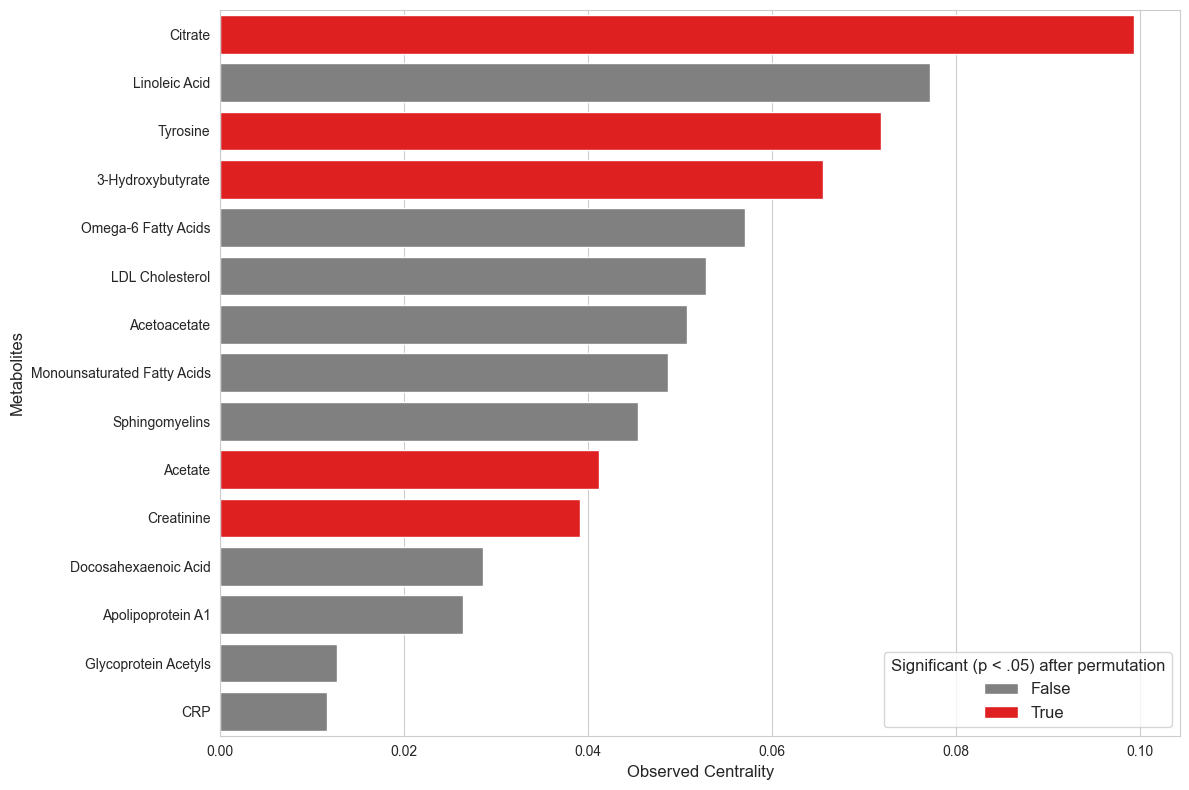

In [153]:

# Convert the observed centrality dictionary to a DataFrame
df = pd.DataFrame(observed_centrality.items(), columns=["Metabolite", "Observed Centrality"])

# Sort the DataFrame by observed centrality in descending order and select the top 16 metabolites
df = df.sort_values(by="Observed Centrality", ascending=False).head(15)

# Add a column to indicate whether each metabolite is significant
df["Significant"] = df["Metabolite"].isin(significant_metabolites)

# Set up the plot
plt.figure(figsize=(12, 8))  # Adjusted size for better readability
sns.barplot(
    x="Observed Centrality",
    y="Metabolite",
    hue="Significant",
    dodge=False,
    data=df,
    palette={True: "red", False: "gray"},  # Red for significant, gray for non-significant
)

# Add labels, title, and legend
plt.xlabel("Observed Centrality", fontsize=12)
plt.ylabel("Metabolites", fontsize=12)

plt.legend(
    title="Significant (p < .05) after permutation",
    loc="lower right",
    fontsize=12,
    title_fontsize=12,
)

# Improve layout and display the plot
plt.tight_layout()

plt.savefig("centrality.tiff", dpi=600, bbox_inches='tight')  
plt.show()
